# Install dependencies

In [2]:
import sys
!{sys.executable} -m pip install pillow matplotlib scikit-image scikit-learn

# Load libraries & define paths

In [2]:
import numpy as np
from skimage.io import imsave, imread
from skimage.segmentation import slic
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import cv2 as cv # need to execute "pip install opencv-python" in the terminal to install module
import numpy as np
import os
import rasterio
from skimage import exposure, filters

In [3]:
# this is the path to the images from your current folder. To adapt
INPUT_DIR = "data/"

# View some images

In [4]:
EXAMPLE_PATH1 = INPUT_DIR + 'EO_Browser_images-2018_0407/B02.tiff'
EXAMPLE_PATH2 = INPUT_DIR + 'EO_Browser_images-2018_0407/True_color.tiff'
EXAMPLE_PATH3 = INPUT_DIR + 'EO_Browser_images-2018_0407/SWIR.tiff'

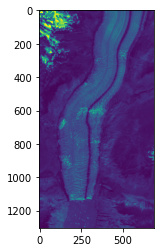

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


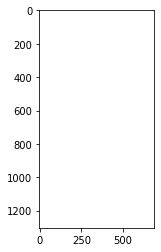

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


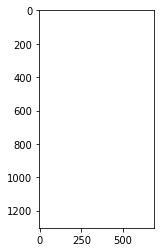

In [5]:
raster1 = rasterio.open(EXAMPLE_PATH1)
array1 = raster1.read()
array1 = array1.transpose(1, 2, 0)

plt.figure()
plt.imshow(array1)
plt.show()

raster2 = rasterio.open(EXAMPLE_PATH2)
array2 = raster2.read()
array2 = array2.transpose(1, 2, 0)

plt.figure()
plt.imshow(array2)
plt.show()

raster3 = rasterio.open(EXAMPLE_PATH3)
array3 = raster3.read()
array3 = array3.transpose(1, 2, 0)

plt.figure()
plt.imshow(array3)
plt.show()

# 0. Normalising the images with opencv
Since some images' values are out of range, we need to normalise.

Normalisation of 
- bands 2, 3, 4, 8A, 11, 12 (should change nothing visually)
- SWIR image
- true color image

In [6]:
def get_normalized_image(image, percentiles=(2, 98)):
    """
    Rescale image to values between 0 to 255 (capping outlier values) 
    
    Parameters
    ==================
    image: Numpy array
        Image numpy array with shape (height, width, num_bands)
    
    percentiles: tuple
        Tuple of min and max percentiles to cap outlier values
    
    Returns
    ==================
    output: Numpy array
        Normalized image numpy array
    
    """
    output = np.zeros_like(image)
    for k in range(image.shape[2]): # for each band
        p_min, p_max = np.percentile(image[:, :, k], percentiles)
        output[:, :, k] = exposure.rescale_intensity(image[:, :, k], 
                            in_range=(p_min, p_max), out_range=(0, 255))
    return output.astype(np.uint8)

In [7]:
to_norm = ['B02', 'B03', 'B04', 'B8A', 'B11', 'B12', 'SWIR', 'True_color']

In [8]:
for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file 
        print(CURRENT_PATH)
        for img in to_norm:
            input_path = CURRENT_PATH + '/' + img + '.tiff'
            # Open raster and save into numpy array
            raster = rasterio.open(input_path)
            array = raster.read()
            # Reshpae to get height x width x bands
            array = array.transpose(1, 2, 0)
            # Normalise the image by calling function
            norm_img = get_normalized_image(array, percentiles=(2, 98))
            output_path = CURRENT_PATH + '/' + img + '_norm.tiff'
            imsave(output_path, norm_img)
            print(img + ' has been normalised')

data/EO_Browser_images-2020_2110
B02 has been normalised
B03 has been normalised
B04 has been normalised
B8A has been normalised
B11 has been normalised
B12 has been normalised
SWIR has been normalised
True_color has been normalised
data/EO_Browser_images-2018_0407
B02 has been normalised
B03 has been normalised
B04 has been normalised
B8A has been normalised
B11 has been normalised
B12 has been normalised
SWIR has been normalised
True_color has been normalised
data/EO_Browser_images-2019_0308
B02 has been normalised
B03 has been normalised
B04 has been normalised
B8A has been normalised
B11 has been normalised
B12 has been normalised
SWIR has been normalised
True_color has been normalised
data/EO_Browser_images-2020_0609
B02 has been normalised
B03 has been normalised
B04 has been normalised
B8A has been normalised
B11 has been normalised
B12 has been normalised
SWIR has been normalised
True_color has been normalised
data/EO_Browser_images-2019_2210
B02 has been normalised
B03 has bee

### Visualise some images

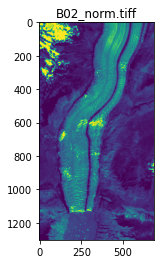

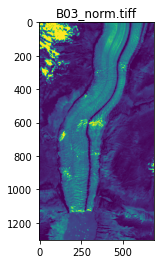

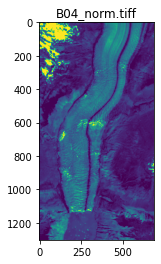

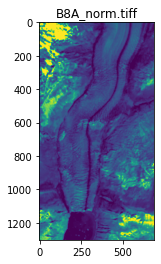

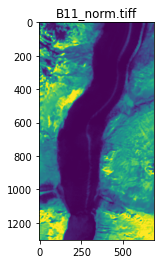

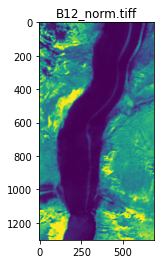

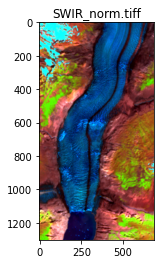

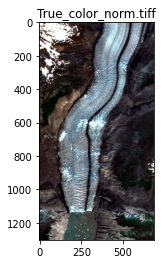

In [11]:
normed_imgs = ['B02_norm.tiff', 'B03_norm.tiff', 'B04_norm.tiff', 'B8A_norm.tiff', 'B11_norm.tiff', 'B12_norm.tiff', 'SWIR_norm.tiff', 'True_color_norm.tiff']

for img in normed_imgs:
    NEW_PATH = INPUT_DIR + 'EO_Browser_images-2018_0407/' + img #path to a picture
    img_read = imread(NEW_PATH, plugin='pil') # call PIL to read the file corectly

    plt.figure()
    plt.title(img)
    plt.imshow(img_read)
    plt.show()

# 1. Create new spectral indices (features)

## NDSI
NDSI =  (B3 - B11)/(B3 + B11)

In [12]:
def NDSI(input_B3, input_B11, output_path):
    """
    Input: path to B3 band .tif and B11 .tif
    ===========
    Output: NDSI.tif
    """
    
    B3 = imread(input_B3, plugin='pil').astype(np.float32)
    B11 = imread(input_B11, plugin='pil').astype(np.float32)
    ndsi = np.zeros_like(B3)
    ndsi = (B3 - B11)/(B3 + B11)
    imsave(output_path, ndsi)

In [14]:
for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file 
        print(CURRENT_PATH)
        # Find B3 and B11 .tiff files
        input_B3 = CURRENT_PATH + '/B03.tiff'
        input_B11 = CURRENT_PATH + '/B11.tiff'
        # Calculate NDSI and save by calling function
        output_path = CURRENT_PATH + '/NDSI.tiff'
        ndsi = NDSI(input_B3, input_B11, output_path)
        print('NDSI has been calculated')

data/EO_Browser_images-2020_2110
NDSI has been calculated
data/EO_Browser_images-2018_0407
NDSI has been calculated
data/EO_Browser_images-2019_0308
NDSI has been calculated
data/EO_Browser_images-2020_0609
NDSI has been calculated
data/EO_Browser_images-2019_2210
NDSI has been calculated
data/EO_Browser_images-2018_2907
NDSI has been calculated


### View NDSI

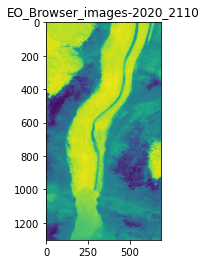

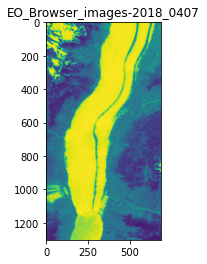

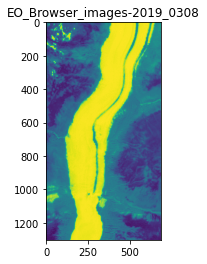

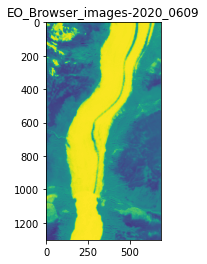

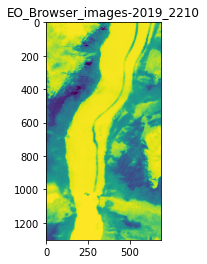

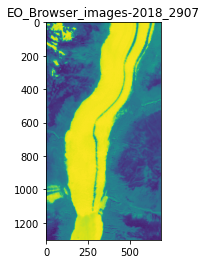

In [17]:
for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file + '/NDSI.tiff'
        
        raster = rasterio.open(CURRENT_PATH)
        array = raster.read()
        array = array.transpose(1,2,0)

        plt.figure()
        plt.title(file)
        plt.imshow(array)
        plt.show()

## NDWI
NDWI = (B3 - B8)/(B3 + B8)

In [18]:
def NDWI(input_B3, input_B8, output_path):
    """
    Input: path to B3 band .tif and B8 .tif
    ===========
    Output: NDWI.tif
    """
    
    B3 = imread(input_B3, plugin='pil').astype(np.float32)
    B8 = imread(input_B8, plugin='pil').astype(np.float32)
    ndsi = np.zeros_like(B3)
    ndwi = (B3 - B8)/(B3 + B8)
    imsave(output_path, ndwi)

In [20]:
for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file 
        print(CURRENT_PATH)
        # Find B3 and B11 .tiff files
        input_B3 = CURRENT_PATH + '/B03.tiff'
        input_B8 = CURRENT_PATH + '/B08.tiff'
        # Calculate NDSI and save by calling function
        output_path = CURRENT_PATH + '/NDWI.tiff'
        ndwi = NDWI(input_B3, input_B8, output_path)
        print('NDWI has been calculated')

data/EO_Browser_images-2020_2110
NDWI has been calculated
data/EO_Browser_images-2018_0407
NDWI has been calculated
data/EO_Browser_images-2019_0308
NDWI has been calculated
data/EO_Browser_images-2020_0609
NDWI has been calculated
data/EO_Browser_images-2019_2210
NDWI has been calculated
data/EO_Browser_images-2018_2907
NDWI has been calculated


### View NDWI

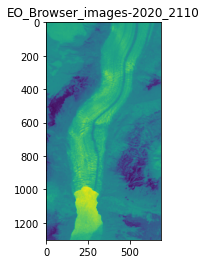

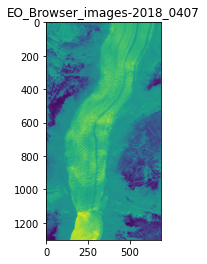

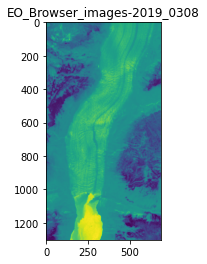

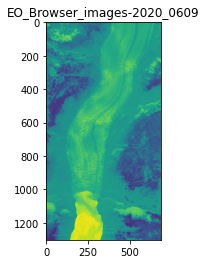

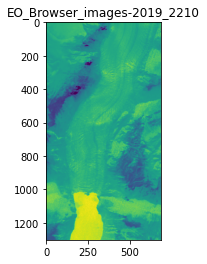

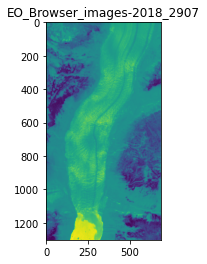

In [21]:
for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file + '/NDWI.tiff'
        
        raster = rasterio.open(CURRENT_PATH)
        array = raster.read()
        array = array.transpose(1,2,0)

        plt.figure()
        plt.title(file)
        plt.imshow(array)
        plt.show()

# 2. Calculate morphologic features (with filters)
https://scikit-image.org/docs/stable/api/skimage.filters.rank.html#module-skimage.filters.rank

https://scikit-image.org/docs/stable/api/skimage.filters.html


- Sobel: finds edges
- Sobel_h: horizontal edges (?)
- Sobel_v: vertical edges (?)
- Difference of gaussians: Find features between low_sigma and high_sigma in size
- Threshold mean: return threshold value based on the mean of grayscale values
- Entropy
- Gradient

In [125]:
def apply_filters(img, list_filters, path):
    """
    Input: list of filters to appy (use skimage names)
    ===========
    Output: Create new .tiffs
    """
    
    for i in range(len(list_filters)):
        new_path = path
        curr_filter = list_filters[i]
        name = curr_filter.__name__
        new_path = new_path + '/' + name + '.tiff'
        print(new_path)
        filtered_img = curr_filter(img)
        imsave(new_path, filtered_img)

In [126]:
### DOESNT WORK YET: PROBLEM SAVING THE OUTPUT

# Example: to change list
list_test = [filters.sobel, filters.gaussian]

for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file
        # Find True_color.tiff files
        input_img = CURRENT_PATH + '/True_color.tiff'
        # Apply filters and save them 
        apply_filters(img, list_test, CURRENT_PATH)
        print('Filters have been applied')

data/EO_Browser_images-2020_2110/sobel.tiff
data/EO_Browser_images-2020_2110/gaussian.tiff
Filters have been applied
data/EO_Browser_images-2018_0407/sobel.tiff


/opt/anaconda3/envs/IPEO/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  


data/EO_Browser_images-2018_0407/gaussian.tiff
Filters have been applied
data/EO_Browser_images-2019_0308/sobel.tiff
data/EO_Browser_images-2019_0308/gaussian.tiff
Filters have been applied
data/EO_Browser_images-2020_0609/sobel.tiff
data/EO_Browser_images-2020_0609/gaussian.tiff
Filters have been applied
data/EO_Browser_images-2019_2210/sobel.tiff
data/EO_Browser_images-2019_2210/gaussian.tiff
Filters have been applied
data/EO_Browser_images-2018_2907/sobel.tiff
data/EO_Browser_images-2018_2907/gaussian.tiff
Filters have been applied


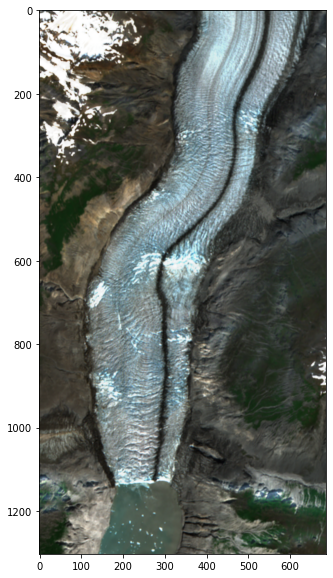

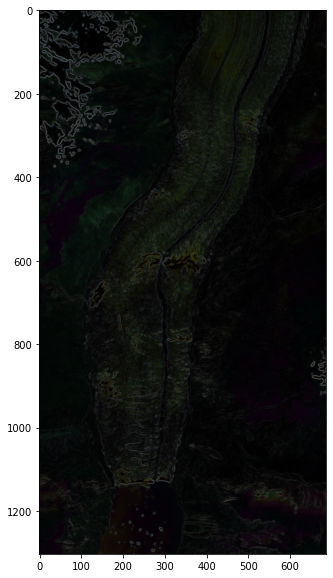

In [118]:
INPUT = TEST_PATH + '/True_color.tiff'
img = imread(INPUT, plugin='pil')
test = filters.sobel(img)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(test)
plt.show()

# 2. Extract regions and other features

### Functions to calculate regions and feature values 
- TO MODIFY: depening on number of bands and format of our data

In [ ]:
def convert_to_shape_pixels_by_bands(data): # SEE IF NEEDED
    num_dimensions = len(data.shape)
    assert(num_dimensions == 2 or num_dimensions == 3)
    if num_dimensions == 3:
        num_bands = data.shape[2]
        return data.reshape((-1, num_bands))
    else:
        return data

def compute_average_feature(data):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    # Get the number of bands
    num_bands = data_2d.shape[1]
    avg_features = np.zeros(num_bands)
    for b in range(num_bands):
        # Compute the average value of each band (use the function np.mean)
        avg_features[b] = np.mean(data_2d[:, b])
    return avg_features

def compute_standard_deviation_feature(data):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    # Compute the standard deviation feature (using the numpy function np.std)
    #       as in the function compute_average_feature iterate over the bands
    #       and compute one value for each band
    num_bands = data_2d.shape[1]
    avg_features = np.zeros(num_bands)
    for b in range(num_bands):
        avg_features[b] = np.std(data_2d[:, b])
    return avg_features

def compute_histogram_feature(data, num_bins=10):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    num_bands = data_2d.shape[1]
    hist_features = np.zeros((num_bands, num_bins)).astype(np.float32)
    for b in range(num_bands):
        # Compute the histogram for each band 
        #       use the function np.histogram(array, bins=num_bins)
        hist, boundaries = np.histogram(data_2d[:, b], bins=num_bins)
        hist_features[b, :] = hist
    # Return a 1D array containing all the values
    return hist_features.flatten()

def compute_image_features_from_regions(image, segmentation_map):
    num_regions = len(np.unique(segmentation_map))
    all_features = []
    for id_region in range(num_regions):
        # Obtain pixel values of each regions, with shape (num_pixels x num_bands)
        pixel_values = image[segmentation_map==id_region]
        # Compute the average, standard deviation and histogram features
        #       and concatenated them unsing the function (np.concatenate)
        avg = compute_average_feature(pixel_values)
        features = compute_standard_deviation_feature(pixel_values)
        hist_features = compute_histogram_feature(pixel_values)
        features = np.concatenate([avg, features, hist_features])
        # Add concatenated features to the variable all_features
        all_features.append(features)
    # convert list to numpy array of shape: (num_regions x num_bands)
    return np.array(all_features).astype(np.float32)

### Compute for all our images

In [ ]:
total_num_images = ... 

for image_number in range(1, total_num_images + 1):
    # Read image
    image_path = INPUT_DIR + "images/" + ... # add path name
    image = imread(image_path)
    # Segment image using SLIC (use the parameter n_segments=1000)
    segmented_image = slic(image, n_segments=1000, start_label=0)
    # Save SLIC regions
    regions_path = INPUT_DIR + "regions/" + ... # add path name
    imsave(regions_path, segmented_image.astype(np.uint32))
    print("Regions saved in " + regions_path)
    # Compute features
    region_features = compute_image_features_from_regions(image, segmented_image)
    # Save features
    region_features_path = INPUT_DIR + "features/" +... # add path name
    np.save(region_features_path, region_features)
    print("Features saved in " + region_features_path)

# 2. Create training dataset

### Split dataset into train/validation/test
- TO COMPLETE

In [ ]:
# Defining which images will belong to the train, test, and validation sets
train_images = [...] 
test_images = [...]
validation_images = [..]

### Function to get labels per region

In [ ]:
def get_label_per_region(segmented_image, label_map):
    """
    Returns a 1D numpy array that contains the label for each region, shape: (num_regions)
            For each region, we obtain the label that has the largest intersection with it
    """
    num_regions = len(np.unique(segmented_image))
    num_labels = len(np.unique(label_map))
    region_labels = []
    for region_id in range(num_regions):
        mask_region = segmented_image == region_id #Select a region. Gives a matrix with True/False
        
        intersection_per_label = []
        for label_id in range(num_labels):
            mask_label = label_map == label_id #Select a label
            # Compute intersection of each region with each label
            intersection = np.sum(mask_region * mask_label) # We look in label only where region mask is true. Then we count number of each label with the sum.
            intersection_per_label.append(intersection)
        
        intersection_per_label = np.array(intersection_per_label)
        # Obtain the index of the label with largest intersection
        selected_label = np.argmax(intersection_per_label)
        region_labels.append(selected_label)
    
    return np.array(region_labels).astype(np.uint32)

### Create training targets and features 
TO CHANGE:
- We don't have the ground truth: need to compute it ?

In [ ]:
all_train_region_features = []
all_train_region_labels = []

for image_number in train_images: # to adapt
    # Read segmented image
    segmented_image_path = INPUT_DIR + "regions/" + ... 
    segmented_image = imread(segmented_image_path)
    # Read ground truth image
    gt_path = INPUT_DIR + "gt/" + ...
    gt_image = imread(gt_path)
    # TODO: Get labels per region using the function "get_label_per_region" defined above
    region_labels = get_label_per_region(segmented_image, gt_image)
    # Add current region labels to the variable all_train_region_labels
    all_train_region_labels.append(region_labels)
    # Read features using the function: np.load(file_path.npy)
    region_features_path = INPUT_DIR + "features/" + ...
    region_features = np.load(region_features_path)
    # Add current region features to the variable all_train_region_features
    all_train_region_features.append(region_features)

# Tranforming the list all_train_region_labels in an array of shape: (num_all_regions)
train_labels = np.concatenate(all_train_region_labels)
print("train_labels shape " + str(train_labels.shape))
# Tranforming the list all_train_region_features in an array of shape: (num_all_regions, num_features)
train_features = np.concatenate(all_train_region_features)
print("train_features shape " + str(train_features.shape))

# 3. Normalize

In [ ]:
mean_per_feature = np.mean(train_features, axis=0)
std_per_feature = np.std(train_features, axis=0)
norm_train_features = (train_features - mean_per_feature) / std_per_feature

# 4. Train a Random Forest classifier

In [ ]:
classifier = RandomForestClassifier(random_state=10)
classifier.fit(norm_train_features, train_labels)

# 5. Function to prediction classification

In [ ]:
def predict_classification_maps_and_get_accuracy(classifier, image_numbers, input_dir, save_predictions=False):
    list_predictions = []
    list_gt_labels = []
    for image_number in image_numbers:
        # Read segmented image
        segmented_image_path = INPUT_DIR + "regions/" + ...
        segmented_image = imread(segmented_image_path)
        # Read features using the function: np.load(file_path.npy)
        region_features_path = INPUT_DIR + "features/" + ...
        region_features = np.load(region_features_path)
        # Normalize features by substracting the mean and dividing by the standard deviation (of the train set) 
        norm_region_features = (region_features - mean_per_feature) / std_per_feature
        # Predict label of regions 
        label_predictions = classifier.predict(norm_region_features)
        # Compute label predictions per pixel
        predicion_map = np.zeros(segmented_image.shape).astype(np.uint8)
        num_regions = len(np.unique(segmented_image))
        for region_id in range(num_regions):
            # Set the label predicted for a region to all the pixels of that region
            predicion_map[segmented_image==region_id] = label_predictions[region_id]
        
        list_predictions.append(predicion_map.flatten())
        
        if save_predictions:
            # Save prediction map image
            prediction_map_path = INPUT_DIR + "prediction_map_" + ...
            imsave(prediction_map_path, predicion_map)
        
        # Get ground truth label
        gt_path = INPUT_DIR + "gt/" + ...
        gt = imread(gt_path)
        
        list_gt_labels.append(gt.flatten())
    
    all_predictions = np.concatenate(list_predictions)
    all_gt_labels = np.concatenate(list_gt_labels)
    accuracy = accuracy_score(all_gt_labels, all_predictions)
    conf_matrix = confusion_matrix(all_gt_labels, all_predictions)
                     
    return accuracy, conf_matrix


def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Ground Truth', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

# 6. Computer performance on validation set

In [ ]:
acc_val, conf_matrix_val = predict_classification_maps_and_get_accuracy(classifier, validation_image_numbers, input_dir)
print(acc_val)
print(conf_matrix_val)

In [ ]:
plot_confusion_matrix(conf_matrix_val)

# 7. Hyperparameter tuning

In [ ]:
# List of paramaters to evaluate in the validation set
n_estimators_values = [20, 50, 100, 200]
max_depth_values = [5, 10, 20, None]

In [ ]:
# Initialise best_val_accuracy, best_depth and best_n_estimators
best_val_accuracy = -1
best_depth = None
best_n_estimators = None

for n_estimators_val in n_estimators_values:
    for max_depth_val in max_depth_values:
        print("eval n_estimators_val {} max_depth_val {}".format(n_estimators_val, max_depth_val))
        classifier = RandomForestClassifier(random_state=10, n_estimators=n_estimators_val, max_depth=max_depth_val)
        classifier.fit(norm_train_features, train_labels)
        val_acc, conf_matrix_val = predict_classification_maps_and_get_accuracy(classifier, validation_image_numbers, input_dir)
        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_depth = max_depth_val
            best_n_estimators = n_estimators_val
            print(val_acc)
            
print("Best max depth: " +str(best_depth))
print("Best number estimators: "+str(best_n_estimators))        

# 8. Train final model & predict on test set

In [ ]:
classifier = RandomForestClassifier(random_state=10, n_estimators=best_n_estimators, max_depth=best_depth)
classifier.fit(norm_train_features, train_labels)
accuracy, conf_matrix = predict_classification_maps_and_get_accuracy(classifier, test_image_numbers, input_dir, save_predictions=True)

In [ ]:
best_acc_test, best_conf_matrix_test = predict_classification_maps_and_get_accuracy(classifier, test_image_numbers, input_dir, save_predictions=True)
print(best_acc_test)
print(best_conf_matrix_test)

# 9. View results --> modify function

In [ ]:
import matplotlib.pyplot as plt

def display_label_image(label_map):
    colors = np.array([[255, 255, 255], # Impervious: white
                       [0, 0, 255],     # Building: Blue
                       [0, 255, 255],   # Low vegetation: cyan
                       [0, 255, 0]])    # Tree: green
    colors = colors.astype(np.uint8)
    color_map = np.zeros((label_map.shape[0], label_map.shape[1], 3)).astype(np.uint8)
    for label_id in range(colors.shape[0]):
        color_map[label_map == label_id] = colors[label_id, :]
    plt.figure(figsize = (11,11)) 
    plt.imshow(color_map)

In [ ]:
prediction_map_path = input_dir + "prediction_map_" +str(4) + ".tif" #need to change image number and select one of the saved ones
prediction_map = imread(prediction_map_path)
display_label_image(prediction_map)

# 10. Compute ice melting